# 对活动进行聚类

对Kaggle数据中的“活动”进行聚类，数据来源： https://www.kaggle.com/c/event-recommendation-engine-challenge/data 。

events.csv文件包含了“活动”的信息，共110维特征，前9列为：event_id, user_id, start_time, city, state, zip, country, lat, and lng；后101列为词频：count_1，count_2， ...，count_100，count_other。

根据活动的关键词（count_1, count_2, ..., count_100，count_other属性）做聚类，并计算CH_scores。


--------------------------------------------------------------------------------
# 1. 读取数据，抽取出训练集和测试集中出现的event

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

import matplotlib.pyplot as plt

In [2]:
# 读取训练集train.csv和测试集test.cv出现的活动

dtrain = pd.read_csv('train.csv')
dtest = pd.read_csv('test.csv')

train_events = dtrain['event'] 
test_events = dtest['event'] 

total_events = set(set(train_events) | set(test_events))
total_events = list(total_events)

print('总的事件个数：',len(total_events))
 

总的事件个数： 13418


In [3]:
# 读取文件'events.csv'

import linecache  
events = linecache.getlines("events.csv") 

In [5]:
# 用linecache读取的格式是列表格式的，再转换为dataframe格式

columns=events[0].strip().split(',')   
data=[]
for e in events[1:100001]:            # 读10万个数据，读取全部数据太慢
    e=e.strip().split(',')
    data.append(e)

events_data=pd.DataFrame(data=data,columns=columns)
events_data.head()

,event_id,user_id,start_time,city,state,zip,country,lat,lng,c_1,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
0,684921758,3647864012,2012-10-31T00:00:00.001Z,,,,,,,2,...,0,1,0,0,0,0,0,0,0,9
1,244999119,3476440521,2012-11-03T00:00:00.001Z,,,,,,,2,...,0,0,0,0,0,0,0,0,0,7
2,3928440935,517514445,2012-11-05T00:00:00.001Z,,,,,,,0,...,0,0,0,0,0,0,0,0,0,12
3,2582345152,781585781,2012-10-30T00:00:00.001Z,,,,,,,1,...,0,0,0,0,0,0,0,0,0,8
4,1051165850,1016098580,2012-09-27T00:00:00.001Z,,,,,,,1,...,0,0,0,0,0,0,0,0,0,9


In [8]:
# 从文件'events.csv'中抽取出只在训练集和测试集中出现的event，并抽取出活动的关键词(count_1, count_2, ..., count_100，count_other属性) 
 
col_all = list(events_data.columns) 
col_events = [col_all[0]]
for i in range(9,len(col_all)):
    col_events.append(col_all[i])
total_events = pd.DataFrame(data=total_events,columns=['event'])
 
events = events_data.loc[events_data['event_id'].isin(total_events['event'])][col_events]
events.head()

,event_id,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
0,684921758,2,0,2,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,9
1,244999119,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,3928440935,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
3,2582345152,1,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,1051165850,1,1,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,9


小结1：  
1) 从文件‘events.csv’中的300w+个数据中读取了10w个数据，从中抽取只在训练集和测试集中出现的事件'event'。    
2) 对于训练集和测试集中总的13418个事件，只有1125个事件出现在10万个数据中。下面对这1125个101维属性做聚类。


----------------------------------------------------------------
# 2.  对事件进行聚类和计算CH_scores

In [12]:
# 将训练集合拆分成训练集和校验集，在校验集上找到最佳的模型超参数 

y_train = events['event_id']
X_train = events.drop('event_id',axis=1)
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train,y_train, train_size = 0.8,random_state = 0)

In [14]:
# 定义一个聚类数为K的函数，评价聚类算法性能

def K_cluster_analysis(K, X_train, y_train, X_val, y_val):     
    mb_kmeans = MiniBatchKMeans(n_clusters = K)
    mb_kmeans.fit(X_train)               
    y_val_pred = mb_kmeans.predict(X_val)

    CH_score = metrics.silhouette_score(X_train,mb_kmeans.predict(X_train))
    v_score = metrics.v_measure_score(y_val,y_val_pred)     
    print('CH_score of train for K = %d: '%K,CH_score)
    print('v_score of test for K = %d: '%K,v_score)
    
    return CH_score,v_score 

In [15]:
# 查看不同聚类数K时训练集和测试集的CH_score
    
Ks = [5,10,15,20,30,40,50,60,70,80,90,100]
CH_scores = []
v_scores = []
for K in Ks:
    ch,v = K_cluster_analysis(K, X_train_part, y_train_part, X_val, y_val)
    CH_scores.append(ch)
    v_scores.append(v)

CH_score of train for K = 5:  0.6384152193653
v_score of test for K = 5:  0.3389150865722689
CH_score of train for K = 10:  0.5664588484465491
v_score of test for K = 10:  0.4465950159193707
CH_score of train for K = 15:  0.2594589118639235
v_score of test for K = 15:  0.5609104919076188
CH_score of train for K = 20:  0.21609859799430753
v_score of test for K = 20:  0.6148694069557753
CH_score of train for K = 30:  0.23952497847829682
v_score of test for K = 30:  0.6901303056125722
CH_score of train for K = 40:  0.1292846151743428
v_score of test for K = 40:  0.7329695442816114
CH_score of train for K = 50:  0.19577692065053523
v_score of test for K = 50:  0.751192457390855
CH_score of train for K = 60:  0.2156352350212626
v_score of test for K = 60:  0.7843388594889223
CH_score of train for K = 70:  0.2218236110804366
v_score of test for K = 70:  0.7868948180256802
CH_score of train for K = 80:  0.20646915089023316
v_score of test for K = 80:  0.8074967138230259
CH_score of train for 

Text(0,0.5,'v_scores')

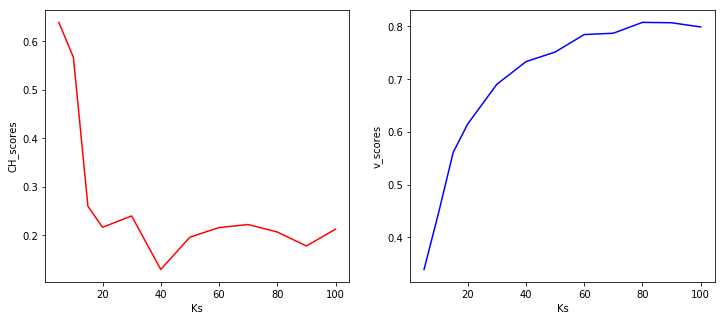

In [16]:
# 绘制不同聚类数目K下的CH_score和v_score,找到最佳模型／参数（分数最高）

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(Ks,np.array(CH_scores),'r-')
plt.xlabel('Ks')
plt.ylabel('CH_scores')

plt.subplot(122)
plt.plot(Ks,np.array(v_scores),'b-')
plt.xlabel('Ks')
plt.ylabel('v_scores')


小结2：    
1) 将训练集合拆分成训练集和校验集，对训练集事件的101维属性在不同聚类数K下进行聚类，并在校验集上评估。     
2) 当聚类数K变化的时候，开始时CH_score随着K的增大而迅速减小，当聚类数K=5时，得到的CH_score最大，为0.6384；当聚类数K=10时，CH_score减少为0.5665；当聚类数K超过20(K>20)以后，CH_score随着K的增大而减小缓慢，变化不显著，在0.2附近波动。     
3) 当聚类数K变化的时候，开始时v_score随着K的增大而迅速增大，当聚类数K=5时，v_score为0.3389；当聚类数K=10时，v_score为0.4466；当聚类数K超过30(K320)以后，v_score随着K的增大而缓慢增大，v_score大于0.7。     
4) 用内部评价法CH_score和外部评价法v_score得到的变化趋势相反的原因：CH_score是根据事件的101维属性来分析这些众多特征聚类的本质特点，v_score是分析聚类结果与事件的id('event_id')的相近性，而事件的id可能与101维属性并无很强的相关性。所以还是应该用CH_score来评价聚类效果。

---------------------------------------- 
# 3.  结果显示/分析 

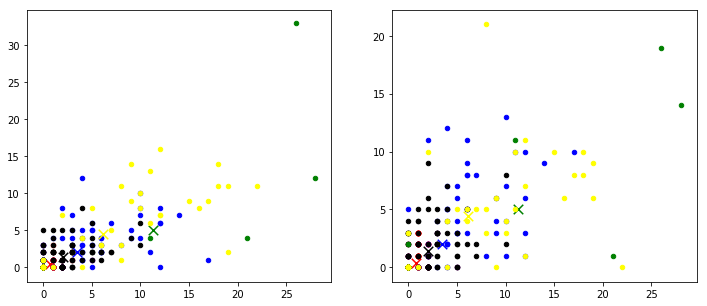

In [24]:
# 显示聚类数K=5时的结果
 
colors = ['red','blue','black','green','yellow','orange','cyan','#e24fff','#524C90','#845868'] # 每一类用一种颜色 
n_clusters = 5
mb_kmeans = MiniBatchKMeans(n_clusters = n_clusters)
mb_kmeans.fit(X_train)
y_train_pred = mb_kmeans.labels_ 
centers = mb_kmeans.cluster_centers_

X_train = np.array(X_train)

plt.figure(figsize=(12,5))
plt.subplot(121)
for i in range(n_clusters):
    index = np.nonzero(y_train_pred==i)[0]
    x = X_train[index,0]
    y = X_train[index,1]
    for j in range(len(x)):
        if j<100:
            plt.scatter(x[j],y[j],color=colors[i],s=20)
    plt.scatter(centers[i,0],centers[i,1],marker='x',color=colors[i],s=90)

plt.subplot(122)
for i in range(n_clusters):
    index = np.nonzero(y_train_pred==i)[0]
    x = X_train[index,0]
    y = X_train[index,2]
    for j in range(len(x)):
        if j<100:
            plt.scatter(x[j],y[j],color=colors[i],s=20)
    plt.scatter(centers[i,0],centers[i,1],marker='x',color=colors[i],s=90)

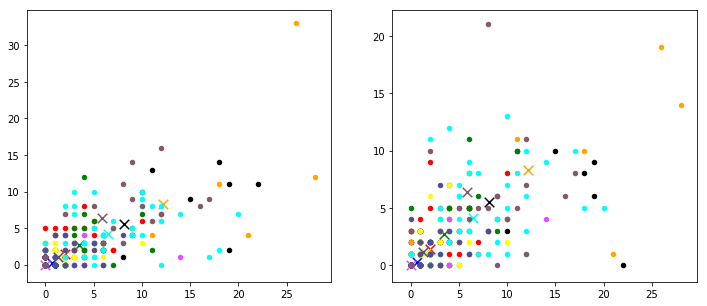

In [25]:
# 显示聚类数K=10时的结果
n_clusters = 10
mb_kmeans = MiniBatchKMeans(n_clusters = n_clusters)
mb_kmeans.fit(X_train)
y_train_pred = mb_kmeans.labels_ 
centers = mb_kmeans.cluster_centers_

X_train = np.array(X_train)

plt.figure(figsize=(12,5))
plt.subplot(121)
for i in range(n_clusters):
    index = np.nonzero(y_train_pred==i)[0]
    x = X_train[index,0]
    y = X_train[index,1]
    for j in range(len(x)):
        if j<50:
            plt.scatter(x[j],y[j],color=colors[i],s=20)
    plt.scatter(centers[i,0],centers[i,1],marker='x',color=colors[i],s=90)

plt.subplot(122)
for i in range(n_clusters):
    index = np.nonzero(y_train_pred==i)[0]
    x = X_train[index,0]
    y = X_train[index,100]
    for j in range(len(x)):
        if j<50:
            plt.scatter(x[j],y[j],color=colors[i],s=20)
    plt.scatter(centers[i,0],centers[i,1],marker='x',color=colors[i],s=90)

小结3：  
1) 聚类效果并不太好，虽然在聚类数K=5时，CH_score=0.6384，但是还是有些簇的点是重合在一起的。在聚类数K=10时，也是好多不同簇的点重合在一起。

# 总结：   
1) 从文件‘events.csv’中的300w+个数据中读取了10w个数据，从中抽取在训练集和测试集中出现的13418个事件，只有1125个事件出现在10万个数据中。   
2) 将训练集合拆分成训练集和校验集，对训练集事件的101维属性在不同聚类数K下进行聚类。当聚类数K变化的时候，开始时CH_score随着K的增大而迅速减小，当聚类数K=5时，得到的CH_score最大，为0.6384；当聚类数K=10时，CH_score减少为0.5665；当聚类数K超过20(K>20)以后，CH_score随着K的增大而减小缓慢，变化不显著，在0.2附近波动。          
3) 随着聚类数K变化，用内部评价法CH_score和外部评价法v_score得到的分值变化方向相反，是由于事件的id众多，可能与101维属性并无很强的相关性。 